# 1D-Latent Variational Autoencoder on a 2D Ring

This notebook demonstrates a VAE with a 1D latent variable trained on a noisy 2D ring dataset.
Figures are shown inline and also saved to `figs/`.

In [1]:
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

FIG_DIR = 'figs'
os.makedirs(FIG_DIR, exist_ok=True)


## Data: noisy 2D ring

In [2]:
N = 4000
R = 2.0
sigma_data = 0.08

theta = 2*np.pi*np.random.rand(N)
x = np.stack([R*np.cos(theta), R*np.sin(theta)], axis=1)
x += sigma_data*np.random.randn(N, 2)

x_torch = torch.tensor(x, dtype=torch.float32)


## Encoder and Decoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )
        self.mu = nn.Linear(64, 1)
        self.logvar = nn.Linear(64, 1)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, z):
        return self.net(z)

enc = Encoder()
dec = Decoder()


## Training via ELBO

In [4]:
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-3)
beta = 1.0
batch_size = 256
epochs = 300

def elbo_loss(x):
    mu, logvar = enc(x)
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    z = mu + std*eps
    x_hat = dec(z)
    recon = ((x - x_hat)**2).sum(dim=1).mean()
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta*kl

for ep in range(epochs):
    perm = torch.randperm(N)
    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        loss = elbo_loss(x_torch[idx])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (ep+1) % 100 == 0:
        print(f'Epoch {ep+1}, loss={loss.item():.4f}')


Epoch 100, loss=2.1017
Epoch 200, loss=2.0985
Epoch 300, loss=2.0310


## Reconstructions and Generations

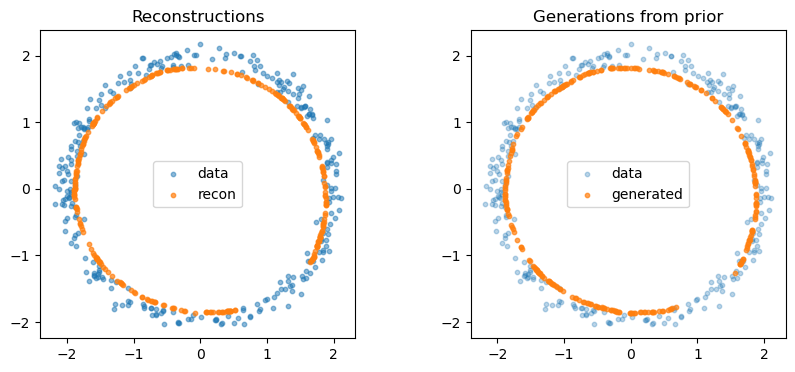

Saved figure to figs/ring_vae_recon_and_gen.png


In [5]:
# Select a subset for visualization
idx = np.random.choice(N, size=300, replace=False)
x_sub = x_torch[idx]

with torch.no_grad():
    mu, logvar = enc(x_sub)
    z = mu
    x_recon = dec(z).numpy()

z_prior = torch.randn(300, 1)
with torch.no_grad():
    x_gen = dec(z_prior).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(x_sub[:,0], x_sub[:,1], s=10, alpha=0.5, label='data')
axs[0].scatter(x_recon[:,0], x_recon[:,1], s=10, alpha=0.7, label='recon')
axs[0].set_title('Reconstructions')
axs[0].set_aspect('equal')
axs[0].legend()

axs[1].scatter(x_sub[:,0], x_sub[:,1], s=10, alpha=0.3, label='data')
axs[1].scatter(x_gen[:,0], x_gen[:,1], s=10, alpha=0.7, label='generated')
axs[1].set_title('Generations from prior')
axs[1].set_aspect('equal')
axs[1].legend()

fig.subplots_adjust(wspace=0.25)
path = os.path.join(FIG_DIR, 'ring_vae_recon_and_gen.png')
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved figure to', path)


### Latent Coordinate vs. Geometry of the Ring

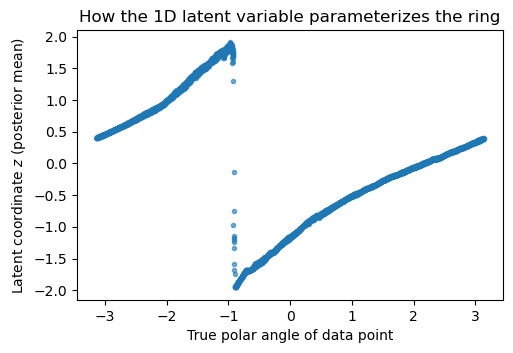

Saved figure to figs/ring_vae_latent_vs_angle.png


In [9]:
# ------------------------------------------------------------
# Extra figure: latent coordinate vs. ring geometry (robust cell)
# ------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) Get data array from common variable names
if "X" in globals():
    X_np = np.asarray(X)
elif "x" in globals():
    X_np = np.asarray(x)
else:
    raise NameError("Could not find data array. Expected a variable named `X` or `x` with shape (N,2).")

# 2) Convert to tensor on the same device as the encoder
device = next(enc.parameters()).device
X_t = torch.tensor(X_np, dtype=torch.float32, device=device)

# 3) Encode to latent mean
enc.eval()
with torch.no_grad():
    mu, logvar = enc(X_t)
    z_mu = mu.squeeze().detach().cpu().numpy()

# 4) Compute polar angle of original data points
angles = np.arctan2(X_np[:, 1], X_np[:, 0])

# 5) Sort by angle for a clearer plot
idx = np.argsort(angles)
angles_sorted = angles[idx]
z_sorted = z_mu[idx]

# 6) Plot + save + show
plt.figure(figsize=(5.5, 3.5))
plt.plot(angles_sorted, z_sorted, ".", alpha=0.6)
plt.xlabel("True polar angle of data point")
plt.ylabel("Latent coordinate $z$ (posterior mean)")
plt.title("How the 1D latent variable parameterizes the ring")

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)
path = os.path.join(FIG_DIR, "ring_vae_latent_vs_angle.png")
plt.savefig(path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure to {path}")
